# Tohoku tsunami inversion
## Inversion using discrete adjoint

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
from time import clock

In [3]:
from thetis import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import GenericSolveBlock

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.misc import gaussian, ellipse

_[Misc plotting functions]_

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [6]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        try:
            plot_field(field, fig, axes[i])
        except AttributeError:
            plot_mesh(field, fig, axes[i])
    return axes

In [7]:
level = 0
# level = 1
# level = 2

op = TohokuOptions(level=level)
op.gauges.pop('21418')  # This pressure gauge isn't within the domain

mesh = op.default_mesh

boundary_conditions = {
    100: ['freeslip', 'dirichlet'],
    200: ['freeslip'],
    300: ['freeslip'],
}

basis_centres = [(0.7e+06, 4.2e+06), ]

### Forward model

As before, consider the shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with boundary conditions

$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta|_{\Gamma_D}\equiv0.
$$

Assume zero initial velocity and expand the initial surface over a radial basis:

$$
    \mathbf u|_{t=0}\equiv\boldsymbol0,\qquad
    \eta|_{t=0}=\sum_{k=1}^N m_kg_k,
$$

where $m_k$ are (constant in space) control parameters and $g_k$ are Gaussians.

Choose an initial guess for the basis coefficient

In [8]:
R = FunctionSpace(mesh, "R", 0)
m0 = Function(R).assign(10.0)

In [9]:
def get_fields(fs):
    elev_space = fs.sub(1)
    b = Function(elev_space, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(elev_space))
    f = Function(elev_space, name="Coriolis parameter").assign(op.set_coriolis(elev_space))
    g = Constant(op.g)
    return b, f, g

### Quantity of Interest

Again, we have the QoI

$$
J(\mathbf u,\eta)=\frac12\sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb1_g\big(\:\eta(x,t)-\eta_g(t)\:\big)^2\;\mathrm dx\;\mathrm dt,
$$

where $\mathbb1_g$ is an indicator function related to a sufficiently small neighbourhood of gauge $g$.

In [10]:
def sampled_timeseries(g, sample=1):
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t, d, running = [], [], []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        for i in range(num_lines):
            time, dat = f.readline().split()
            time, dat = float(time), float(dat)
            if np.isnan(dat):
                continue
            running.append(dat)
            if i % sample == 0 and i > 0:
                t.append(0.5*(time + time_prev))
                d.append(np.mean(running))
                running = 0
                time_prev = time
                running = []
    return scipy.interpolate.interp1d(t, d, bounds_error=False, fill_value='extrapolate')

In [11]:
def get_basis_functions(fs, xy_skew=(48e+03, 96e+03), angle=pi/12):
    basis_functions = []
    for loc in basis_centres:
        basis_function = Function(fs)
        psi, phi = basis_function.split()
        phi.interpolate(gaussian([loc + xy_skew, ], fs.mesh(), rotation=angle))
        basis_functions.append(basis_function)
    return basis_functions

In [12]:
def print_debug(msg, debug=False):
    if debug:
        print(msg)

In [13]:
def solve_forward(ctrls, gradient=False, debug=True):
    print("FORWARD SOLVE FOR GRADIENT CALCULATION" if gradient else "FORWARD SOLVE")
    if isinstance(ctrls, Function):
        ctrls = [ctrls, ]
    
    # --- Setup function spaces
    
    fs = VectorFunctionSpace(mesh, "CG", 2)*FunctionSpace(mesh, "CG", 1)
    P0 = FunctionSpace(mesh, "DG", 0)
    
    # -- Setup fields
    
    b, f, g = get_fields(fs)
    
    # --- Setup PDE
    
    dtc = Constant(op.dt)
    
    u, eta = TrialFunctions(fs)
    z, zeta = TestFunctions(fs)

    q_ = Function(fs)
    u_, eta_ = q_.split()

    a = inner(z, u)*dx + inner(zeta, eta)*dx
    L = inner(z, u_)*dx + inner(zeta, eta_)*dx
    
    n = FacetNormal(mesh)

    def G(uv, elev):
        F = g*inner(z, grad(elev))*dx
        F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
        F += -inner(grad(zeta), b*uv)*dx
        for tag in boundary_conditions:
            if 'freeslip' not in boundary_conditions[tag]:
                F += inner(zeta*n, b*uv)*ds(tag)
        return F

    a += 0.5*dtc*G(u, eta)
    L += -0.5*dtc*G(u_, eta_)

    q = Function(fs)
    u, eta = q.split()

    bcs = []
    for tag in boundary_conditions:
        if 'dirichlet' in boundary_conditions[tag]:
            bcs.append(DirichletBC(fs.sub(1), 0, tag))

    params = {
        "snes_type": "ksponly",
        "ksp_type": "gmres",
        "pc_type": "fieldsplit",
        "pc_fieldsplit_type": "multiplicative",
    }

    problem = LinearVariationalProblem(a, L, q, bcs=bcs)
    solver = LinearVariationalSolver(problem, solver_parameters=params)
    
    # --- Setup initial condition / control
    
    basis_functions = get_basis_functions(fs)
    try:
        assert len(basis_functions) == len(ctrls)
    except AssertionError:
        msg = "Number of basis functions and number of basis coefficients do not match ({:d} vs {:d})"
        raise ValueError(msg.format(len(basis_functions), len(ctrls)))
    q_.project(sum(m_i*phi_i for m_i, phi_i in zip(ctrls, basis_functions)))
    
    # --- Setup QoI
    
    radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
    for gauge in op.gauges:
        op.gauges[gauge]['indicator'] = interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,), ], mesh), P0)
        op.gauges[gauge]['interpolator'] = sampled_timeseries(gauge, sample=60 if gauge[0] == 'P' else 1)
        
    op.end_time = 1440.0
        
    times = []

    # --- Time integrate
    
    t = 0.0
    iteration = 0
    J = 0
    eta_obs = Constant(0.0)
    weight = Constant(1.0)
    tic = clock()
    msg = "    simulation time {:4.1f} minutes    wallclock time {:4.1f} seconds"
    while t < op.end_time:
        times.append(t)
        if iteration % 48 == 0:
            toc = clock() - tic
            print_debug(msg.format(t/60, toc), debug=debug)
            tic = clock()

        # Solve forward equation at current timestep
        solver.solve()

        # Time integrate QoI
        weight.assign(0.5 if np.allclose(t, 0.0) else 1.0)
        u, eta = q.split()
        for gauge in op.gauges:
            indicator = op.gauges[gauge]['indicator']

            # Interpolate observations
            obs = float(op.gauges[gauge]['interpolator'](t))
            eta_obs.assign(obs)

            # Continuous form of error
            J += assemble(weight*dtc*0.5*indicator*(eta - eta_obs)**2*dx)

        # Increment
        q_.assign(q)
        t += op.dt
        iteration += 1

    assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
    toc = clock() - tic
    print_debug(msg.format(t/60, toc), debug=debug)
    print_debug("    Quantity of interest = {:.8e}".format(J), debug=debug)
    
    weight.assign(0.5)
    u, eta = q.split()
    for gauge in op.gauges:
        indicator = op.gauges[gauge]['indicator']

        # Interpolate observations
        obs = float(op.gauges[gauge]['interpolator'](t))
        eta_obs.assign(obs)

        # Continuous form of error
        J += assemble(weight*dtc*0.5*indicator*(eta - eta_obs)**2*dx)
    
    return J, q

In [48]:
def reduced_functional(m, debug=True, **kwargs):
    J, q = solve_forward(m, debug=debug)
    return ReducedFunctional(J, Control(m), **kwargs)

Let's take a look at the forward solution.

FORWARD SOLVE
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 18.9 seconds
    simulation time  8.0 minutes    wallclock time 17.8 seconds
    simulation time 12.0 minutes    wallclock time 19.5 seconds
    simulation time 16.0 minutes    wallclock time 18.9 seconds
    simulation time 20.0 minutes    wallclock time 18.5 seconds
    simulation time 24.0 minutes    wallclock time 17.7 seconds
    Quantity of interest = 6.63522212e+13


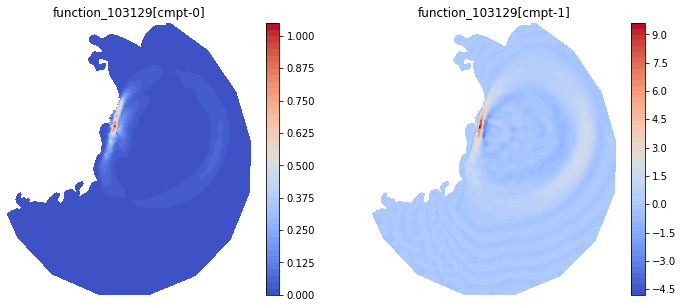

In [33]:
tape = get_working_tape()
tape.clear_tape()
m0 = Function(R).assign(10.0)
J, q = solve_forward(m0)
plot_fields(*q.split());

In [34]:
g = compute_gradient(J, Control(m0))

Let's take a look at the adjoint solution.

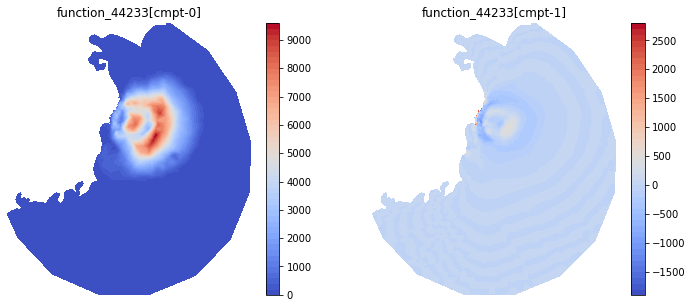

In [19]:
tape = get_working_tape()
blocks = tape.get_blocks()
solve_blocks = [block for block in blocks if isinstance(block, GenericSolveBlock)]
q_star0 = solve_blocks[0].adj_sol
plot_fields(*q_star0.split());

## Taylor Test

To check that the gradient is consistent, we can apply a Taylor remainder test.
Denote by $\widehat J=\widehat J(m)$ the reduced functional and consider the first order Taylor remainder

$$
    T_1(h):=\left|\:\widehat J(m+h\delta m) - \widehat J(m)\:\right|,
$$

for some search direction $\delta m$ and step length $m$.
In addition, consider the second order Taylor remainder

$$
    T_2(h):=\left|\:\widehat J(m+h\delta m) - \widehat J(m) - h\;\mathrm d\widehat J\cdot\delta m\:\right|.
$$

where we propose that $\mathrm d\widehat J$ is the gradient of $\widehat J$ w.r.t. the control $m$.
Continuity of the reduced functional implies that $\lim_{h\rightarrow0}T_1(h)=0$ at rate $\mathcal O(h)$.
Provided that $\mathrm d\widehat J$ is indeed the gradient, we also have that $\lim_{h\rightarrow0}T_2(h)=0$.
Moreover, we expect that this convergence is achieved at rate $\mathcal O(h^2)$.

The Taylor test simply verifies that the second order convergence is achieved.

In [85]:
def taylor_test(m_init, h_init=1):
    print(20*"=" + "TAYLOR TEST" + 20*"=")
    tape = get_working_tape()
    tape.clear_tape()
    m = Function(R).assign(m_init)
    
    # Choose a random search direction
    delta_m = np.random.rand(1)
    
    # Evaluate the reduced functional and gradient at the specified control value
    Jm = solve_forward(m)[0]
    dJm = compute_gradient(Jm, Control(m)).dat.data
    m = np.array([m, ])
    tape.clear_tape()
    
    # Check that the Taylor remainders decrease quadratically
    with stop_annotating():
        remainders = np.zeros(3)
        for i in range(3):
            h = h_init*pow(0.5, i)
            print("h = {:.4e}".format(h))
            J_step = solve_forward(m+h*delta_m)[0]
            remainders[i] = abs(J_step - Jm - h*np.dot(dJm, delta_m))
            print("Taylor remainder = {:.4e}".format(remainders[i]))
            if i > 0:
                ratio = remainders[i-1]/remainders[i]
                try:
                    assert ratio > 1.95
                except AssertionError:
                    msg = "Taylor remainders do not decrease quadratically (ratio {:.4e})"
                    raise ConvergenceError(msg.format(ratio))
    print(16*"=" + "TAYLOR TEST PASSED!" + 16*"=")

In [86]:
taylor_test(4.5)

====================TAYLOR TEST====================
FORWARD SOLVE
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 17.1 seconds
    simulation time  8.0 minutes    wallclock time 18.1 seconds
    simulation time 12.0 minutes    wallclock time 17.7 seconds
    simulation time 16.0 minutes    wallclock time 19.2 seconds
    simulation time 20.0 minutes    wallclock time 19.2 seconds
    simulation time 24.0 minutes    wallclock time 19.5 seconds
    Quantity of interest = 6.52032091e+13
h = 1.0000e+00
FORWARD SOLVE
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 10.5 seconds
    simulation time  8.0 minutes    wallclock time 10.5 seconds
    simulation time 12.0 minutes    wallclock time 10.8 seconds
    simulation time 16.0 minutes    wallclock time 11.2 seconds
    simulation time 20.0 minutes    wallclock time 11.3 seconds
    simulation time 24.0 minute

## Parameter space exploration

Since we have a one-dimensional control parameter space, we can easily explore the parameter space to see how it looks.

In [80]:
n = 6
control_values = np.linspace(5.0, 10.0, n)
func_values = np.zeros(n)
with stop_annotating():
    for i, m in enumerate(control_values):
        m0.assign(m)
        func_values[i] = solve_forward(m0, debug=False)[0]
        print("{:2d}: control value {:.4e}  functional value {:.4e}".format(i, m, func_values[i]))

FORWARD SOLVE
 0: control value 5.0000e+00  functional value 6.5088e+13
FORWARD SOLVE
 1: control value 6.0000e+00  functional value 6.4843e+13
FORWARD SOLVE
 2: control value 7.0000e+00  functional value 6.4859e+13
FORWARD SOLVE
 3: control value 8.0000e+00  functional value 6.5135e+13
FORWARD SOLVE
 4: control value 9.0000e+00  functional value 6.5671e+13
FORWARD SOLVE
 5: control value 1.0000e+01  functional value 6.6467e+13


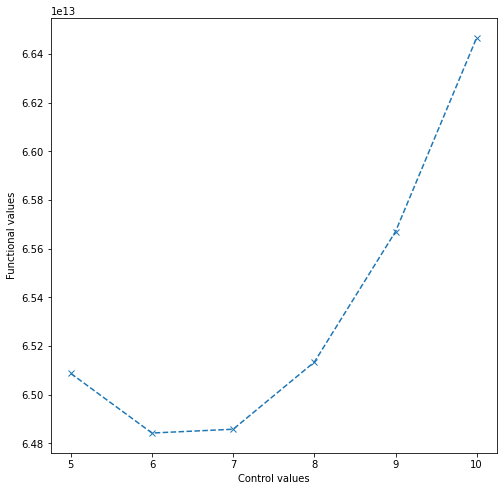

In [81]:
fig, axes = plt.subplots(figsize=(8, 8))

axes.plot(control_values, func_values, '--x')
axes.set_xlabel("Control values");
axes.set_ylabel("Functional values");

This plot will be very useful in interpreting the progress of the minimisation routine.

## Inversion for a single basis function coefficient

Now that we have functions for solving the forward problem and computing the gradient, we can apply a quasi-Newton optimisation method such as BFGS to optimise the control parameter.
BFGS may be expressed in pseudocode as

* Choose initial guess $m_0$
* $i:=0$
* while not converged:
    - solve forward problem with control $m_i$ to evaluate QoI as $J_i$
    - solve adjoint problem
    - compute gradient $g_i$ for control $m_i$
        
    - Approximate Hessian:
        * if $i = 0$ then $H_i:=I$
        * else:
            - $s := m_i - m_{i-1}$
            - $y := g_i - g_{i-1}$
            - $H_i := \left(I - \frac{sy^T}{y^Ts}\right) H_{i-1} \left(I - \frac{ys^T}{y^Ts}\right) + \frac{ss^T}{y^Ts}$
            
    - compute search direction $p_i := H_ig_i$
    - compute step length $\alpha_i$ using line search
    - take step $m_{i+1} := m_i + \alpha_ip_i$
    - check convergence
    - $i = i+1$
        
where $I$ is the identity matrix and each $m_i$ is a vector of control parameters.

In [61]:
m_init = np.array([9.0, ])  # it looks like the minimum lies in [6, 7]

control_values_opt = []
func_values_opt = []
gradient_values_opt = []

def derivative_cb_post(j, dj, m):
    control_values_opt.append(m)
    func_values_opt.append(j)
    gradient_values_opt.append(dj)
    print("control {:}  functional  {:.8e}  gradient {:}".format(m, j, dj))

opt_parameters = {
    'maxiter': 5,
    'disp': True,
#     'gtol': 1.0e-02,
    'gtol': 1.0,
}

tape = get_working_tape()
tape.clear_tape()
m = Function(R).assign(10.0)

# Evaluate the reduced functional
J = reduced_functional(m, debug=False, derivative_cb_post=derivative_cb_post)

m_opt = minimize(J, method='BFGS', options=opt_parameters)
print("Optimised control parameter = {:.4e}".format(*m_opt.dat.data))

Optimised control parameter = 6.4399e+00


Let's view the progress of the optimisation routine superimposed on the sample of the parameter space explored previously.

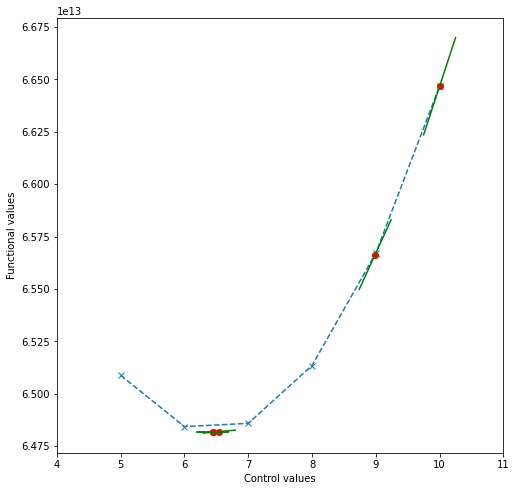

In [82]:
fig, axes = plt.subplots(figsize=(8, 8))

axes.plot(control_values, func_values, '--x')
ctrl_plot = [ctrl.dat.data[0] for ctrl in control_values_opt]
gradient_plot = [gradient.dat.data[0] for gradient in gradient_values_opt]
axes.plot(ctrl_plot, func_values_opt, 'o', color='r')

delta_m = 0.25
for m, f, g in zip(ctrl_plot, func_values_opt, gradient_plot):
    x = np.array([m - delta_m, m + delta_m])
    axes.plot(x, g*(x-m) + f, '-', color='g')

axes.set_xlabel("Control values");
axes.set_ylabel("Functional values");
axes.set_xlim([4, 11]);
# axes.set_ylim([scaling*6.45e+13, scaling*6.65e+13]);
# axes.set_ylim([scaling*3.8e+12, scaling*4.2e+12]);